In [46]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import pyedflib
from pyedflib import highlevel

In [70]:
# Data directory (only on Nathan's machine, just for exploring)
path = 'nathan'

psg_path = os.path.join(path, 'SC4001E0-PSG.edf')
hyp_path = os.path.join(path, 'SC4001E0-Hypnogram.edf')

signals, signal_headers, header = highlevel.read_edf(psg_path)

signal_headers

[{'label': 'EEG Fpz-Cz',
  'dimension': 'uV',
  'sample_rate': 100.0,
  'sample_frequency': 100.0,
  'physical_max': 192.0,
  'physical_min': -192.0,
  'digital_max': 2047,
  'digital_min': -2048,
  'prefilter': 'HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'transducer': 'Ag-AgCl electrodes'},
 {'label': 'EEG Pz-Oz',
  'dimension': 'uV',
  'sample_rate': 100.0,
  'sample_frequency': 100.0,
  'physical_max': 196.0,
  'physical_min': -197.0,
  'digital_max': 2047,
  'digital_min': -2048,
  'prefilter': 'HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'transducer': 'Ag-AgCl electrodes'},
 {'label': 'EOG horizontal',
  'dimension': 'uV',
  'sample_rate': 100.0,
  'sample_frequency': 100.0,
  'physical_max': 1009.0,
  'physical_min': -1009.0,
  'digital_max': 2047,
  'digital_min': -2048,
  'prefilter': 'HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'transducer': 'Ag-AgCl electrodes'},
 {'label': 'Resp oro-nasal',
  'dimension': '',
  'sample_rate': 1.0,
  'sample_frequency': 1.0,
  'physical_m

# Explore train data

In [71]:
data_path = 'sleep-cassette-aggregate.npz'

data = np.load(data_path)

In [72]:
data.files

['labels',
 'SC4711',
 'SC4712',
 'SC4401',
 'SC4402',
 'SC4661',
 'SC4662',
 'SC4371',
 'SC4372',
 'SC4231',
 'SC4232',
 'SC4571',
 'SC4572',
 'SC4001',
 'SC4002',
 'SC4431',
 'SC4432',
 'SC4511',
 'SC4512',
 'SC4561',
 'SC4562',
 'SC4141',
 'SC4142',
 'SC4731',
 'SC4732',
 'SC4161',
 'SC4162',
 'SC4771',
 'SC4772',
 'SC4501',
 'SC4502',
 'SC4491',
 'SC4492',
 'SC4021',
 'SC4022',
 'SC4271',
 'SC4272',
 'SC4081',
 'SC4082',
 'SC4481',
 'SC4482',
 'SC4531',
 'SC4532',
 'SC4101',
 'SC4102',
 'SC4041',
 'SC4042',
 'SC4541',
 'SC4542',
 'SC4111',
 'SC4112',
 'SC4421',
 'SC4422',
 'SC4121',
 'SC4122',
 'SC4281',
 'SC4282',
 'SC4581',
 'SC4582',
 'SC4741',
 'SC4742',
 'SC4641',
 'SC4642',
 'SC4191',
 'SC4192',
 'SC4591',
 'SC4592',
 'SC4291',
 'SC4292',
 'SC4381',
 'SC4382',
 'SC4611',
 'SC4612',
 'SC4351',
 'SC4352',
 'SC4331',
 'SC4332',
 'SC4411',
 'SC4412',
 'SC4051',
 'SC4052',
 'SC4451',
 'SC4452',
 'SC4551',
 'SC4552',
 'SC4071',
 'SC4072',
 'SC4761',
 'SC4762',
 'SC4522',
 'SC4171',

In [189]:
train_patients = data['train_patients']
train_patients

array(['SC4111', 'SC4112', 'SC4261', 'SC4262', 'SC4671', 'SC4672',
       'SC4371', 'SC4372', 'SC4751', 'SC4752', 'SC4441', 'SC4442',
       'SC4411', 'SC4412', 'SC4431', 'SC4432', 'SC4091', 'SC4092',
       'SC4522', 'SC4161', 'SC4162', 'SC4631', 'SC4632', 'SC4551',
       'SC4552', 'SC4491', 'SC4492', 'SC4121', 'SC4122', 'SC4421',
       'SC4422', 'SC4731', 'SC4732', 'SC4341', 'SC4342', 'SC4381',
       'SC4382', 'SC4531', 'SC4532', 'SC4011', 'SC4012', 'SC4611',
       'SC4612', 'SC4451', 'SC4452', 'SC4331', 'SC4332', 'SC4561',
       'SC4562', 'SC4761', 'SC4762', 'SC4511', 'SC4512', 'SC4281',
       'SC4282', 'SC4811', 'SC4812', 'SC4071', 'SC4072', 'SC4651',
       'SC4652', 'SC4351', 'SC4352', 'SC4291', 'SC4292', 'SC4181',
       'SC4182', 'SC4471', 'SC4472', 'SC4211', 'SC4212', 'SC4501',
       'SC4502', 'SC4241', 'SC4242'], dtype='<U6')

In [191]:
labels = data['labels']
labels

array(['EEG FPZ-CZ-freq0', 'EEG FPZ-CZ-freq1', 'EEG FPZ-CZ-freq2',
       'EEG FPZ-CZ-freq3', 'EEG FPZ-CZ-freq4', 'EEG PZ-OZ-freq0',
       'EEG PZ-OZ-freq1', 'EEG PZ-OZ-freq2', 'EEG PZ-OZ-freq3',
       'EEG PZ-OZ-freq4', 'EOG HORIZONTAL-freq0', 'EOG HORIZONTAL-freq1',
       'EOG HORIZONTAL-freq2', 'EOG HORIZONTAL-freq3',
       'EOG HORIZONTAL-freq4', 'EMG SUBMENTAL-freq0',
       'EMG SUBMENTAL-freq1', 'EMG SUBMENTAL-freq2',
       'EMG SUBMENTAL-freq3', 'EMG SUBMENTAL-freq4',
       'RESP ORO-NASAL-mean', 'TEMP RECTAL-mean', '_HYPNO-mode'],
      dtype='<U20')

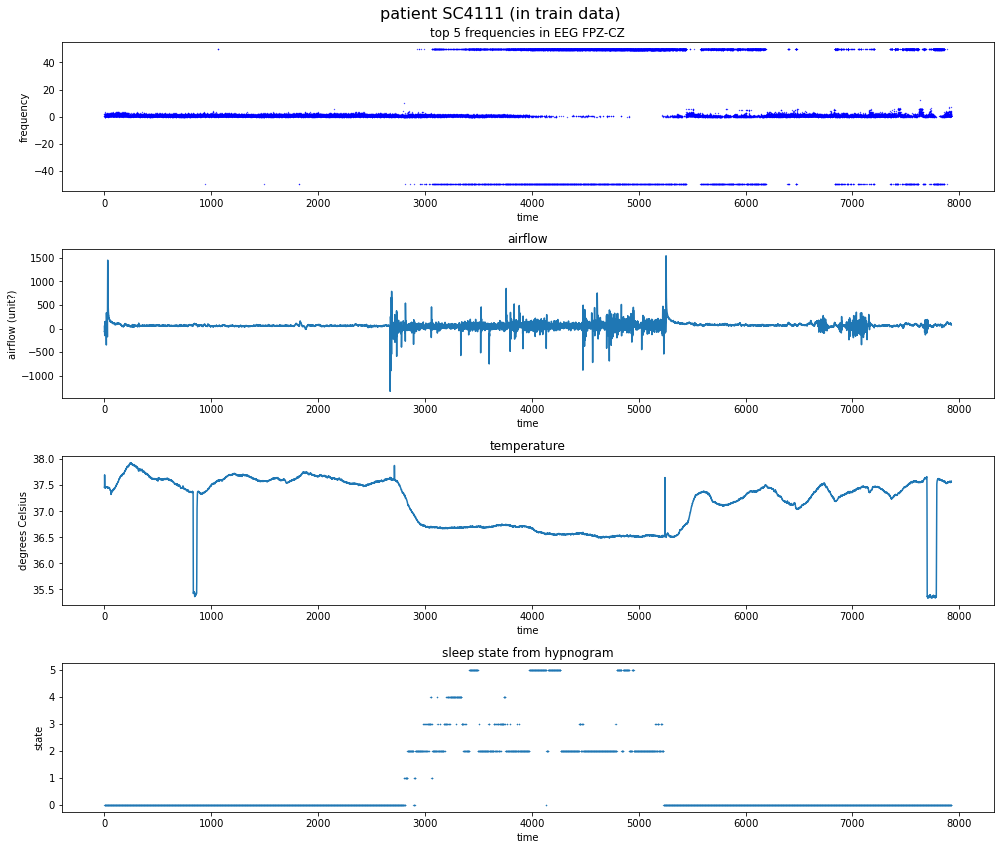

In [253]:
patient_name = 'SC4111'
patient = data[patient_name]

# Number of time steps, number of columns
T, C = patient.shape

fig, axs = plt.subplots(4, 1, figsize=(14, 12))

ax = axs[0]
ticks = range(T)
ax.scatter(ticks, patient[:, 0], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 1], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 2], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 3], s=0.1, color='blue')
ax.scatter(ticks, patient[:, 4], s=0.1, color='blue')
ax.set_title(f'top 5 frequencies in {labels[0][:-6]}')
ax.set_ylabel('frequency')
ax.set_xlabel('time')

ax = axs[1]
ax.plot(patient[:, 20])
ax.set_title('airflow')
ax.set_ylabel('airflow (unit?)')
ax.set_xlabel('time')

ax = axs[2]
ax.plot(patient[:, 21])
ax.set_title('temperature')
ax.set_ylabel('degrees Celsius')
ax.set_xlabel('time')

ax = axs[3]
ax.scatter(range(T), patient[:, -1], s=0.1)
ax.set_title('sleep state from hypnogram')
ax.set_ylabel('state')
ax.set_xlabel('time')

fig.suptitle(f'patient {patient_name} (in train data)', fontsize=16)
fig.tight_layout()
fig.show()

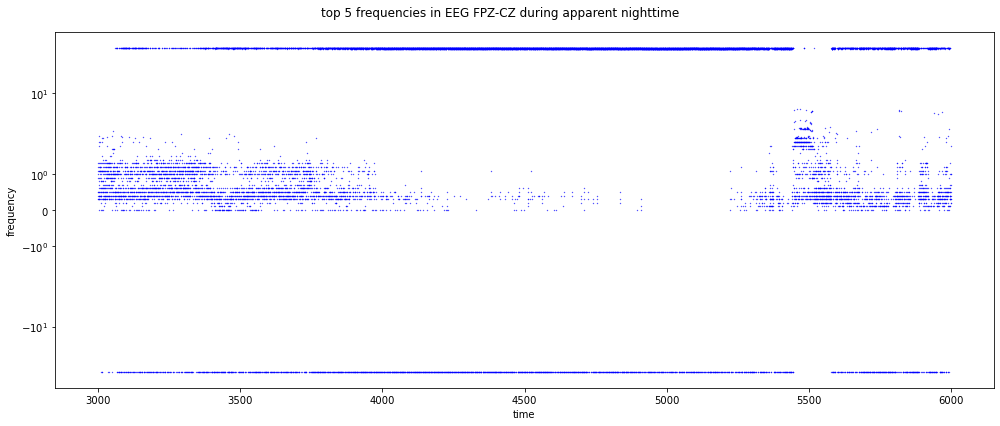

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

start, stop = 3000, 6000
slice = patient[start:stop]
Tslice = slice.shape[0]
ticks = range(start, start + Tslice)

# Scatterplot the values in the first channel (all of the top 5 frequencies)
ax.scatter(ticks, slice[:, 0], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 1], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 2], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 3], s=0.1, color='blue')
ax.scatter(ticks, slice[:, 4], s=0.1, color='blue')

ax.set_yscale('symlog')

ax.set_xlabel('time')
ax.set_ylabel('frequency')

fig.suptitle(f'top 5 frequencies in {labels[0][:-6]} during apparent nighttime')
fig.tight_layout()
fig.show()

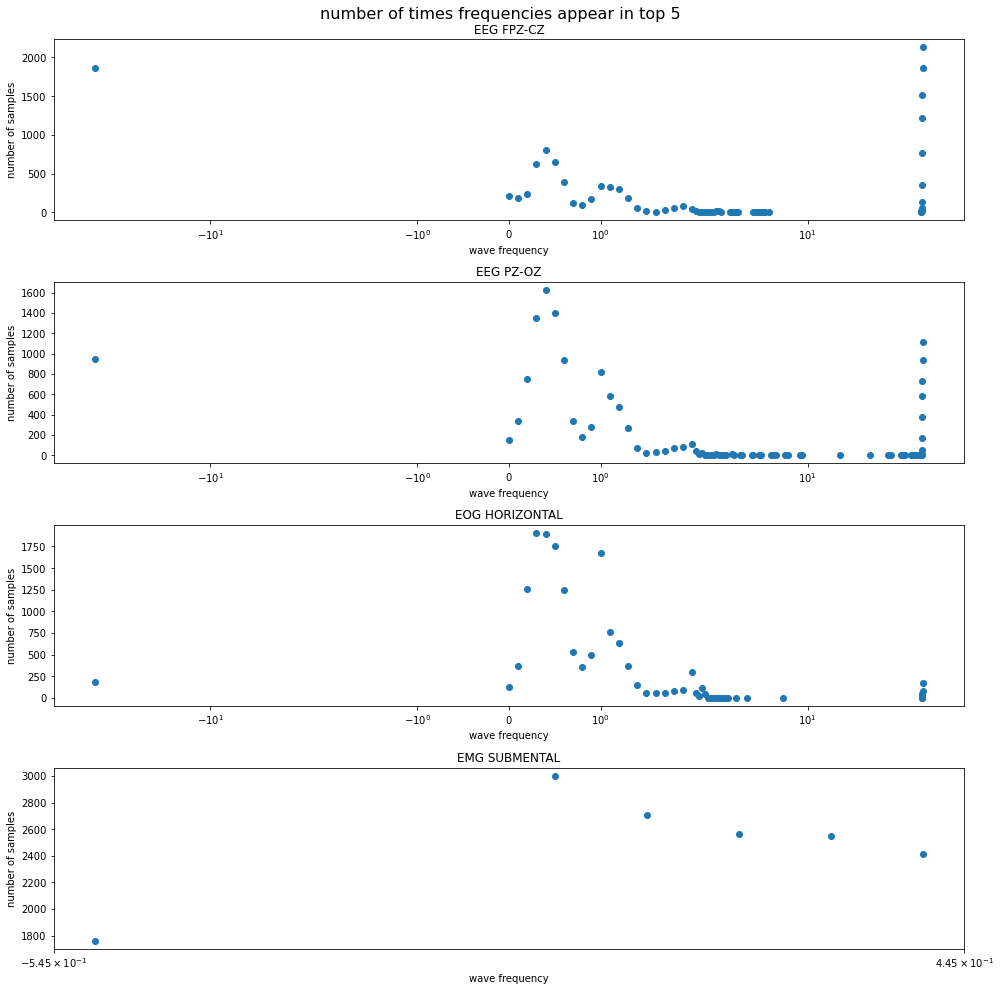

In [243]:
fig, axs = plt.subplots(4, 1, figsize=(14, 14))

for i, ax in enumerate(axs):
  # Get the 5 columns corresponding to the current channel
  df = pd.DataFrame(np.ravel(slice[:, 5*i : 5*(i+1)]))
  
  # Get the value counts for each frequency
  vcs = df.value_counts()
  idx = vcs.index.get_level_values(0).to_numpy()
  vals = vcs.to_numpy()

  ax.scatter(idx, vals)

  ax.set_title(labels[5*i][:-6])
  ax.set_xscale('symlog')
  ax.set_xlabel('wave frequency')
  ax.set_ylabel('number of samples')

fig.suptitle('number of times frequencies appear in top 5', fontsize=16)
fig.tight_layout()
fig.show()

In [269]:
slice[:20, 0], slice[:20, 16]

(array([  0.4,   1. ,   0.9,   1.1,   0.5,   0.5,   1.3,   0.6,   1. ,
          1. ,   0.3,   0. ,   0.4, -50. ,   0.5,   1.1,   0.3,   1.2,
          0.4,   0.6]),
 array([ 0.4, -0.5,  0.2, -0.5,  0.3,  0.1,  0.2,  0.3,  0.4,  0.4,  0.2,
         0.1,  0.3,  0.1,  0.4,  0.2,  0.3,  0.4,  0.3,  0.1]))

In [271]:
from scipy.fft import fft, fftfreq

π = np.pi

5.0

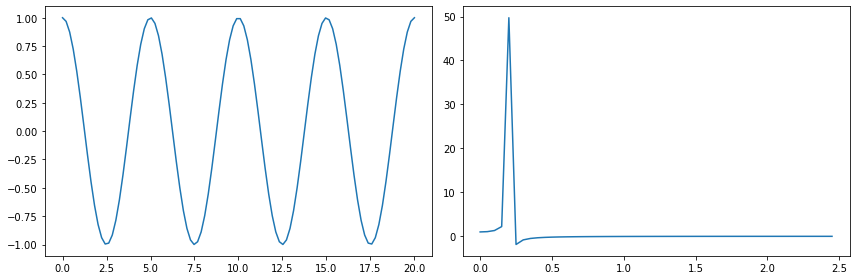

In [399]:
period = np.array([5])
f = lambda t: np.sum(np.cos(2*π/period[:, np.newaxis] * t), axis=0)

t0, tf = 0, 20
tn = 100
tls = np.linspace(t0, tf, tn)

sample_freq = (tf - t0)/tn

samples = f(tls)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
ax.plot(tls, samples)

ax = axs[1]
amps = np.real(fft(samples))
freqs = fftfreq(tn, sample_freq)
# amps = np.concatenate((amps[tn//2:], amps[:tn//2]))
# freqs = np.concatenate((freqs[tn//2:], freqs[:tn//2]))

ax.plot(freqs[:tn//2], amps[:tn//2])

fig.tight_layout()
fig.show()

i = 6
np.stack((amps[:i], freqs[:i]))

1 / freqs[amps.argmax()]

# So using fftfreq (correctly) gets us the frequencies corresponding to the fft amplitutde outputs.
# TODO: Check the output of fftfreq on the 100 Hz and 1 Hz channels, over the 10-second (?) intervals